# Fine-Tuning Bert with Pytorch
## This notebook has the follwing topics 
    1. Dataset Preprocessing
        1a. Load and disply data
        1b. Add extra column label
        1c. Load the BERT tokenizer
        1d. Create sentense pair 
        1e. Tokenization using bert model
        1f. Create dataloader
    2. Training the model 
        2a. Load a pretrained bert model with a classificaiton layer
        2b. Freeze base layer and only train the bottleneck layers
        2c. Train settings
        2d. Train loop
        2e. Save models for later reference
        2f. Display train stats
    3. Inference
        3a. 3a. Load inference data 
        3b. Test example1
        3c. Test example2
        3d. Test example3

In [1]:
import transformers
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm as tqdm
import time
import datetime
import random
import os

In [2]:
## GLOBAL SETTINGS
visualize_index = 10 # Index to be used to test/visualize items
max_len = 128 # Max length of input sentence
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_train_split = .9 # 90% of the data will be used for training and rest will be used for validation
epochs = 5
num_output = 3 
label_dict = {0 : 'contradiction', 1 : 'entailment', 2 : 'neutral'} # output label and there index
batch_size = 64

# 1. Dataset Preprocessing

## 1a. Load and disply data

In [3]:
train_df = pd.read_csv("../dataset/assignment_data_set/train.csv")
print(f"Number of training sentence pairs : {train_df.shape[0]}")

# Display 10 random rows from the data.
train_df.sample(visualize_index)

Number of training sentence pairs : 9349


,gold_label,sentence1,sentence2
1140,neutral,"Two men are playing basketball, and one man is...",The men are on different teams.
5328,neutral,"A white dog, a brown dog, and a black dog frol...",Several dogs are chasing frisbees in a grassy ...
8865,contradiction,The two people are on the end of the dock with...,Two people jumping off a dock into the water.
2807,entailment,A man in a straw hat and another man in a stri...,The men have beverages.
4228,contradiction,A bridal party is posing for a picture outdoors.,The best man is taking pictures from the bache...
9114,neutral,Two backpackers look at scenic mountains.,Two guys are rock climbers.
2041,contradiction,Groups of people are sitting on a curb and the...,groups of people are standing around
7015,neutral,One man watching another man operate heavy mac...,Two workers are outside doing construction work.
7508,neutral,two people are waiting for a train at a station.,They will both get onto the same train together.
8134,contradiction,A young man in a black shirt and an elderly wo...,The man is asleep in the bathtub on the moon.


## 1b. Add extra column label

In [4]:
# Add a column label which we will be using for train labels
# {'contradiction': 0, 'entailment': 1, 'neutral': 2}
train_df["label"] = train_df["gold_label"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
# Display 10 random rows from the data.
train_df.sample(visualize_index)

,gold_label,sentence1,sentence2,label
4784,entailment,Two men and a lady are standing outside.,There are people outside.,1
6633,contradiction,Two girls are walking down the street looking ...,Skipping at a place with no cats and walk into...,0
3492,neutral,A man wearing a red bicycle helmet talking on ...,A man talks on his iphone.,2
368,contradiction,A man in a blue jacket riding a bike,A man is walking his dog.,0
9212,entailment,A woman walking in front of a yellow building.,The woman is walking.,1
1408,neutral,"A young girl wearing a blue, flowered, spaghet...",a silly girl plays near a water bucket,2
7595,neutral,A marching band of kids while at a rodeo.,The kids are playing a song.,2
7239,neutral,A woman in a gray shirt working on papers at h...,Lady working in her desk tensely to completed ...,2
2567,contradiction,A man in a gray sweatshirt and blue jeans is p...,the two men were pulling on the rope,0
8448,contradiction,Two dogs play with tennis ball in field.,Dogs are watching a tennis match.,0


## 1c. Load the BERT tokenizer

In [5]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer from transformer library...')
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer from transformer library...


## 1d. Create sentense pair

In [6]:
# Helper function to create sentence pair from the data frame
def create_sen_pair(dataframe):
    """Trains the model for a fixed number of epochs (iterations on a dataset).

    Arguments:
        dataframe: panda dataframe

    Returns:
        - sen_pairs list. example ['this is sentence1','this is sentence2']
        - correspoding label field value
    """
    sen_pairs = []
    labels = []
    for index, row in tqdm(dataframe.iterrows()):
        each_sen_pair = [row["sentence1"], row["sentence2"]]
        label = row["label"]
        sen_pairs.append(each_sen_pair)
        labels.append(label)
    return sen_pairs, labels

# Train data and train labels
sentence_pairs, labels = create_sen_pair(train_df)

9349it [00:00, 18693.68it/s]


## 1e. Tokenization using bert model

In [7]:
# Helper function for tokenization
def get_tokernized_values(each_sen_pair):
    encoded_dict = tokenizer.encode_plus(
        text=each_sen_pair[0],  # Sentence to encode.
        text_pair=each_sen_pair[1],  # for text pair ## TODO check this??
        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
        max_length=max_len,  # Pad & truncate all sentences.
        pad_to_max_length=True,
        return_attention_mask=True,  # Construct attn. masks.
        return_tensors='pt',  # Return pytorch tensors.
    )
    return encoded_dict['input_ids'], encoded_dict['attention_mask']


# List to strore tokenization outputs for all the sentences
input_ids = []
attention_masks = []

for each_sen_pair in tqdm(sentence_pairs):
    temp_input_ids, temp_attention_mask = get_tokernized_values(each_sen_pair)

    input_ids.append(temp_input_ids)

    attention_masks.append(temp_attention_mask)

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

  0%|          | 0/9349 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/deep/.virtualenvs/pytorch/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2137: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 9349/9349 [00:03<00:00

In [8]:
print('Checking out one tokenized example')
print('---------------------------')
print('Original sentence pair is --> ', sentence_pairs[visualize_index])
print('---------------------------')
print('Tokenized ids -->', input_ids[visualize_index])

Checking out one tokenized example
---------------------------
Original sentence pair is -->  ['Three women, two wearing red shirts and one wearing a purple shirt, and a man, wearing a light blue shirt, jump on a basketball court with balls in their hands.', "Three people's are eating in hotel."]
---------------------------
Tokenized ids --> tensor([  101,  2093,  2308,  1010,  2048,  4147,  2417, 11344,  1998,  2028,
         4147,  1037,  6379,  3797,  1010,  1998,  1037,  2158,  1010,  4147,
         1037,  2422,  2630,  3797,  1010,  5376,  2006,  1037,  3455,  2457,
         2007,  7395,  1999,  2037,  2398,  1012,   102,  2093,  2111,  1005,
         1055,  2024,  5983,  1999,  3309,  1012,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    

## 1f. Create dataloader

In [9]:
# Create a dataset class using torch utils
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(test_train_split * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('Total training samples --> {}'.format(len(train_dataset)))
print('Total validation samples --> {}'.format(len(val_dataset)))

Total training samples --> 8414
Total validation samples --> 935


In [10]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

In [11]:
print('checking out one batch')
x = iter(train_dataloader).next()
print(x[0].shape,x[1].shape,x[2].shape)

checking out one batch
torch.Size([64, 128]) torch.Size([64, 128]) torch.Size([64])


# 2. Training the model 

## 2a. Load a pretrained bert model with a classificaiton layer

In [12]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load pretrained BERT model with a single classification layer on top
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = num_output,
    output_attentions = False,
    output_hidden_states = False
)

# Load model to device
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

## 2b. Freeze base layer and only train the bottleneck layers
    - I tried with and without freezing , performance was still same

In [13]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    p[1].requires_grad = False
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))),p[1].requires_grad)

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    p[1].requires_grad = False
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))), p[1].requires_grad)

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    p[1].requires_grad = True
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))),p[1].requires_grad)

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768) False
bert.embeddings.position_embeddings.weight                (512, 768) False
bert.embeddings.token_type_embeddings.weight                (2, 768) False
bert.embeddings.LayerNorm.weight                              (768,) False
bert.embeddings.LayerNorm.bias                                (768,) False

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768) False
bert.encoder.layer.0.attention.self.query.bias                (768,) False
bert.encoder.layer.0.attention.self.key.weight            (768, 768) False
bert.encoder.layer.0.attention.self.key.bias                  (768,) False
bert.encoder.layer.0.attention.self.value.weight          (768, 768) False
bert.encoder.layer.0.attention.self.value.bias                (768,) False
bert.encoder.layer.0.attention.output.dense.weight        (768, 76

## 2c. Train settings

In [14]:
# Optimizer from hugging face transformers
optimizer = AdamW(
    model.parameters(),
    lr=1e-5,
)

In [15]:
from transformers import get_linear_schedule_with_warmup

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [16]:
# Helper function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Helper function to calculate epoch time
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

## 2d. Train loop

In [17]:
# This training code is based on the `run_glue.py` script here:
# http://mccormickml.com/2019/07/22/BERT-fine-tuning/

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = output.loss
        logits = output.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            output = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
            loss = output.loss
            logits = output.logits
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...
  Batch    40  of    132.    Elapsed: 0:00:27.
  Batch    80  of    132.    Elapsed: 0:00:53.
  Batch   120  of    132.    Elapsed: 0:01:19.

  Average training loss: 1.00
  Training epcoh took: 0:01:27

Running Validation...
  Accuracy: 0.66
  Validation Loss: 0.82
  Validation took: 0:00:04

======== Epoch 2 / 5 ========
Training...
  Batch    40  of    132.    Elapsed: 0:00:26.
  Batch    80  of    132.    Elapsed: 0:00:52.
  Batch   120  of    132.    Elapsed: 0:01:19.

  Average training loss: 0.75
  Training epcoh took: 0:01:26

Running Validation...
  Accuracy: 0.74
  Validation Loss: 0.66
  Validation took: 0:00:04

======== Epoch 3 / 5 ========
Training...
  Batch    40  of    132.    Elapsed: 0:00:26.
  Batch    80  of    132.    Elapsed: 0:00:53.
  Batch   120  of    132.    Elapsed: 0:01:20.

  Average training loss: 0.62
  Training epcoh took: 0:01:28

Running Validation...
  Accuracy: 0.77
  Validation Loss: 0.60
  Validation too

## 2e. Save models for later reference

In [18]:
# Saving the model
output_dir = './final_model_bert/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./final_model_bert/


('./final_model_bert/tokenizer_config.json',
 './final_model_bert/special_tokens_map.json',
 './final_model_bert/vocab.txt',
 './final_model_bert/added_tokens.json')

## 2f. Display train stats

In [19]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.00,0.82,0.66,0:01:27,0:00:04
2,0.75,0.66,0.74,0:01:26,0:00:04
3,0.62,0.60,0.77,0:01:28,0:00:04
4,0.55,0.57,0.78,0:01:27,0:00:04
5,0.52,0.56,0.78,0:01:27,0:00:04


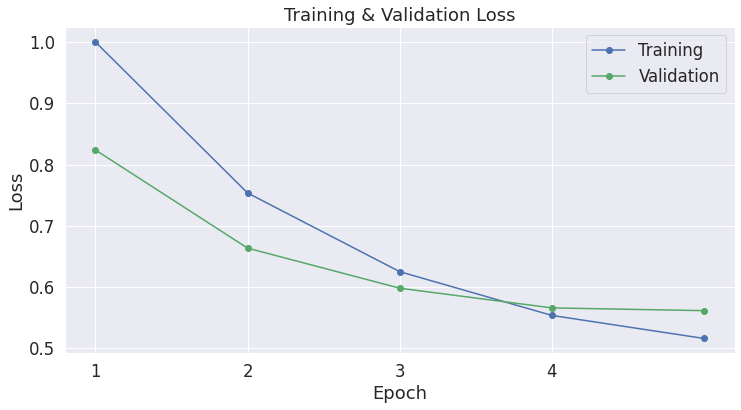

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Inference

In [21]:
# # Load a trained model and vocabulary that you have fine-tuned
# model = BertForSequenceClassification.from_pretrained(output_dir)
# model = model.to(device)
# tokenizer = tokenizer.from_pretrained(output_dir)

## 3a. Load inference data 

In [22]:
test_df = pd.read_csv("../dataset/assignment_data_set/test_sample.csv")
test_label = pd.read_csv("../dataset/assignment_data_set/predicted_sample.csv")

In [23]:
# helper function to test similarity
def test_similarity(test_sentence_pair):
    sen_input_id,sen_attn_mask = get_tokernized_values(test_sentence_pair)
    sen_input_id = sen_input_id.to(device)
    sen_attn_mask = sen_attn_mask.to(device)
    outputs = model(sen_input_id, token_type_ids=None, attention_mask=sen_attn_mask)
    logits = outputs[0]
    logits = logits.argmax(dim = 1)
    logits = logits.to('cpu').numpy()
    return label_dict[logits[0]]

## 3b. Test example1

In [24]:
test_sentence_pair = test_df.sample(n=1)
test_sentence_pair = [test_sentence_pair['sentence1'].values[0], test_sentence_pair['sentence2'].values[0]]
print('test sentece pair -->',test_sentence_pair)
print('--------------------')

# inference
print('predicted class -->',test_similarity(test_sentence_pair))

test sentece pair --> ['A group of people gathered to watch fireworks.', 'There are some guys setting of fireworks.']
--------------------
predicted class --> entailment


/home/deep/.virtualenvs/pytorch/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2137: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## 3b. Test example2

In [27]:
test_sentence_pair = test_df.sample(n=1)
test_sentence_pair = [test_sentence_pair['sentence1'].values[0], test_sentence_pair['sentence2'].values[0]]
print('test sentece pair -->',test_sentence_pair)
print('--------------------')

# inference
print('predicted class -->',test_similarity(test_sentence_pair))

test sentece pair --> ['A woman walks next to a subway exit.', 'A woman is on here way home.']
--------------------
predicted class --> neutral


## 3c. Test example3

In [26]:
test_sentence_pair = test_df.sample(n=1)
test_sentence_pair = [test_sentence_pair['sentence1'].values[0], test_sentence_pair['sentence2'].values[0]]
print('test sentece pair -->',test_sentence_pair)
print('--------------------')

# inference
print('predicted class -->',test_similarity(test_sentence_pair))

test sentece pair --> ['A thin man in a maroon shirt standing next to a pay phone.', 'A man in a maroon shirt is sitting on the train.']
--------------------
predicted class --> contradiction
